# Maze with Q-Network



In [2]:
import numpy as np
from matplotlib.pyplot import *
import tensorflow as tf

left = 0; right = 1; up = 2; down = 3

/home/matjoerg/my_python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Environment

In [50]:
def Maze(position,action):
    dead = False
    actions = {left: [0,-1], right: [0,1], up: [1,0], down: [-1,0]}
    state_matrix = np.array([[1, 1, 1, 1, 1, 1, 1],
                             [1, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0, 1],
                             [1, 0, 0, 0, 0, 0 ,1],
                             [1, 0, 0, 1, 0, 2, 1],
                             [1, 1, 1, 1, 1, 1, 1]])
    
    rewards = [-1, -20, 50]
    
    new_position = position + np.array(actions[action[0]])
    new_state = state_matrix[int(new_position[0]),int(new_position[1])]
    reward = rewards[new_state]
    win = (new_state == 2)
    if new_state == 1 or new_state == 2:
        dead = True
    
    return reward, new_position, dead, win

## Q-network training

### Construct network

In [51]:
# construct network feed-forward graph
tf.reset_default_graph()
inputs = tf.placeholder(shape=[1,2],dtype=tf.float32)
W1 = tf.Variable(tf.random_uniform([2,100],0,0.01))
b1 = tf.Variable(tf.zeros(shape=[1,100]))
W2 = tf.Variable(tf.random_uniform([100,100],0,0.01))
b2 = tf.Variable(tf.zeros(shape=[1,100]))
W3 = tf.Variable(tf.random_uniform([100,4],0,0.01))
b3 = tf.Variable(tf.zeros(shape=[1,4]))

A1 = tf.nn.relu(tf.add(tf.matmul(inputs,W1),b1))
A2 = tf.nn.relu(tf.add(tf.matmul(A1,W2),b2))
Qout = tf.add(tf.matmul(A2,W3),b3)
predict = tf.argmax(Qout,1)

# model optimization
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.AdamOptimizer()
updateModel = trainer.minimize(loss)

### Network training

In [52]:
# learning parameters
y = 0.99
e = 0.05
num_episodes = 10000

# starting position
p0 = [5.,1.]

# save positions and rewards
rList = []
xList = []
yList = []
WList = []
wins = 0
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        if (i+1)%100 == 0:
            print("Episode {}, win rate: {:.4f}".format(i+1,wins/float(i+1)))
        p = p0
        rAll = []
        xAll = [p[1]]
        yAll = [6-p[0]]
        dead = False
        step = 0
        while step < 99:
            step += 1
            # choose action
            a, allQ = sess.run([predict,Qout],feed_dict={inputs:np.array([p])})
            #print(a, allQ)
            if np.random.rand(1) < e:
                a[0] = np.random.randint(0,4)
            # new position and reward
            r, p_new, dead, win = Maze(p,a)
            wins += win
            # estimate next Q' values with network
            Q1 = sess.run(Qout,feed_dict={inputs:np.array([p_new])})
            #print(p,p_new)
            maxQ1 = np.max(Q1)
            # calculate target Q
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            # train network
            _,Wout = sess.run([updateModel,W3],feed_dict={inputs:np.array([p]),nextQ:targetQ})
            p = p_new
            rAll.append(r)
            xAll.append(p[1])
            yAll.append(6-p[0])
            if dead is True:
                break
        rList.append(np.sum(rAll))
        xList.append(xAll)
        yList.append(yAll)
        WList.append(np.sum(Wout))

Episode 100, win rate: 0.0000
Episode 200, win rate: 0.0000
Episode 300, win rate: 0.0000
Episode 400, win rate: 0.0025
Episode 500, win rate: 0.0020
Episode 600, win rate: 0.0017
Episode 700, win rate: 0.0014
Episode 800, win rate: 0.0013
Episode 900, win rate: 0.0011
Episode 1000, win rate: 0.0010
Episode 1100, win rate: 0.0009
Episode 1200, win rate: 0.0008
Episode 1300, win rate: 0.0008
Episode 1400, win rate: 0.0021
Episode 1500, win rate: 0.0020
Episode 1600, win rate: 0.0019
Episode 1700, win rate: 0.0018
Episode 1800, win rate: 0.0017
Episode 1900, win rate: 0.0016
Episode 2000, win rate: 0.0015
Episode 2100, win rate: 0.0014
Episode 2200, win rate: 0.0014
Episode 2300, win rate: 0.0013
Episode 2400, win rate: 0.0013
Episode 2500, win rate: 0.0012
Episode 2600, win rate: 0.0012
Episode 2700, win rate: 0.0015
Episode 2800, win rate: 0.0014
Episode 2900, win rate: 0.0014
Episode 3000, win rate: 0.0013
Episode 3100, win rate: 0.0013
Episode 3200, win rate: 0.0013
Episode 3300, win

In [53]:
Wout

array([[  3.32063442e-04,  -2.78233271e-03,  -2.60008336e-03,
         -1.64093135e-03],
       [ -2.30025873e-03,   3.59205669e-03,  -7.26094993e-04,
          3.98357119e-03],
       [ -1.45943137e-03,   3.43874958e-03,   1.39555102e-03,
          3.08278017e-04],
       [  8.57337553e-04,   5.50930155e-04,  -4.33561532e-03,
          2.26764620e-04],
       [  3.74476984e-03,   1.89663307e-03,  -4.36175196e-03,
         -4.18974273e-03],
       [  7.77773501e-04,   8.65260023e-04,  -3.90776666e-03,
         -4.23330488e-03],
       [  3.99901345e-03,  -3.68378032e-03,  -3.05556040e-03,
          6.17831480e-04],
       [  2.77728075e-03,  -1.32415633e-04,  -3.55374796e-04,
         -6.39840204e-04],
       [ -4.68305359e-03,  -4.21942677e-03,   2.30886391e-03,
         -1.27712241e-03],
       [  2.45523057e-03,   7.89901766e-04,  -2.17446755e-03,
          3.86162591e-03],
       [  9.22615733e-03,   1.45057193e-03,   6.45799082e-05,
         -4.81837243e-03],
       [ -4.13498050e

## Learning curve

Win rate: 0.0016


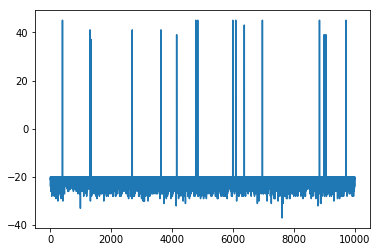

In [54]:
print("Win rate: {}".format(wins/float(num_episodes)))
plot(range(num_episodes),rList)
show()

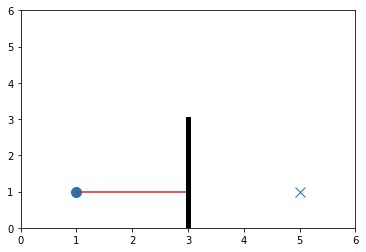

In [55]:
plot(1,1,'C0o',ms=10)
plot(5,1,'C0x',ms=10)
plot(xList[-1],yList[-1],'C3-')
plot([3,3],[0,3],'k-',lw=5)
xlim([0,6])
ylim([0,6])
show()